# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

#### Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

#### Целевой признак:

* Price — цена (евро)

Для успешного выполнения поставленной задачи, будем придерживаться следующего плана:

1. Загрузим и подготовим данные.
2. Обучим разные модели. Для каждой подберем различные гиперпараметры.
3. Проанализируем скорость работы и качество моделей.

## Подготовка данных

In [1]:
#!pip install catboost
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import random

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
#приведем названия столбцев к змеиному регистру
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

#в данных о модели, коробке передач, типе топлива и типе кузова данные заменим на 'unk'(unknown - неизвестно)
df['model'] = df['model'].fillna('unk')
df['vehicle_type'] = df['vehicle_type'].fillna('unk')
df['gearbox'] = df['gearbox'].fillna('unk')
df['fuel_type'] = df['fuel_type'].fillna('unk')

#в столбце not_repaired пропуски заменим на yes подразумевая "не бит, не крашен"
df['not_repaired'].fillna('yes', inplace=True)

Для замены модой некоторых 'unk' в данных о форме кузова напишем функцию:

In [8]:
mvt = df.groupby('model')['vehicle_type'].agg(lambda x:x.value_counts().index[0]).to_dict()

In [9]:
def mvt_inputer(row):
   
    model = row['model']
    veh_type = row['vehicle_type']
    
    if model == 'unk' and veh_type == 'unk':
        return 'unk'
    elif model == 'unk' and veh_type != 'unk':
        return veh_type
    
    return mvt[model]

In [10]:
df['vehicle_type'] = df[['vehicle_type', 'model']].apply(mvt_inputer, axis=1)

In [11]:
df['vehicle_type'].unique()

array(['sedan', 'coupe', 'suv', 'small', 'bus', 'wagon', 'convertible',
       'unk', 'other'], dtype=object)

для некоторых значений нет моды, поэтому 'unk' останется.

In [12]:
df.isna().sum().sum()

0

In [13]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Сложно представить автомобиль стоимостью 0 евро. Это скорее всего аномалия. Заменим все значения в столбце цены менее 50 евро на медиану.

In [14]:
df.loc[df['price'] < 50, 'price'] = df['price'].median()

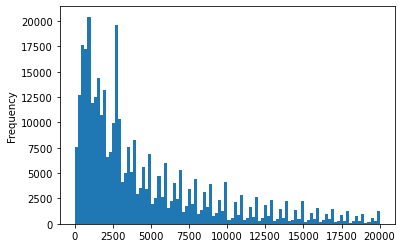

In [15]:
df['price'].plot(kind='hist', bins=100);

Первый серийный автомобиль вышел с конвеера в 1886 году, его и возьмем за нижний порог. За верхний возьмем 2021 год, так как авто 2022 года вряд ли пресутствуют в выборке.

In [16]:
def registration_year_limit(value):
    if value > 2021:
        return 2021
    elif value < 1886:
        return 1886 
    else:
        return value
    
df['registration_year'] = df['registration_year'].apply(registration_year_limit)    

Месяца с порядковым номером 0 в календаре нет, возьмем за 1 все значения равные 0( по аналогии со списками).

In [17]:
df.loc[df['registration_month'] == 0, 'registration_month'] = 1

На июль 2022 года самым мощьным серийным автомобилем является Lotus Evija, Мощность: 2000 л.с., первый серийный автомобиль имел мощьность 0.75л.с.. Этим и ограничим значения в столбце.

In [18]:
def power_limit(value):
    if value > 2000:
        return 2000
    elif value == 0:
        return 0.75
    else:
        return value
    
df['power'] = df['power'].apply(power_limit)   

## Обучение моделей

Подготовим необходимые признаки:

In [19]:
df = df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)
df['vehicle_type'] = df['vehicle_type'].astype('category')
df['gearbox'] = df['gearbox'].astype('category')
df['model'] = df['model'].astype('category')
df['fuel_type'] =df['fuel_type'].astype('category') 
df['brand'] = df['brand'].astype('category')
df['not_repaired'] = df['not_repaired'].astype('category')

In [20]:
cat_features = df.select_dtypes(include='category').columns.to_list()

In [21]:
features = df.drop('price', axis=1)
target = df['price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

### CatBoost

In [22]:
%%time
kf = KFold(n_splits=3, shuffle=True, random_state=12345)
parametrs_cat = {
                 'depth' : [i for i in range(1, 10, 2)],
                }

model_grid_cat = CatBoostRegressor(iterations=500, cat_features=cat_features,  verbose=100)
grid_cat = GridSearchCV(estimator=model_grid_cat, param_grid=parametrs_cat, cv=kf, n_jobs=-1)
grid_cat.fit(features_train, target_train)

print(f'Лучшие параметры модели:{grid_cat.best_params_}')

Learning rate set to 0.173776
0:	learn: 3933.2656722	total: 429ms	remaining: 3m 34s
100:	learn: 1738.6457218	total: 26.1s	remaining: 1m 42s
200:	learn: 1649.8643582	total: 52.2s	remaining: 1m 17s
300:	learn: 1597.7433796	total: 1m 18s	remaining: 51.7s
400:	learn: 1560.3847009	total: 1m 44s	remaining: 25.8s
499:	learn: 1528.5574165	total: 2m 11s	remaining: 0us
Лучшие параметры модели:{'depth': 9}
Wall time: 11min 41s


In [23]:
%%time
model_cat = CatBoostRegressor(iterations=500, depth=9, cat_features=cat_features, verbose=100)
model_cat.fit(features_train, target_train)

Learning rate set to 0.173776
0:	learn: 3933.2656722	total: 298ms	remaining: 2m 28s
100:	learn: 1738.6457218	total: 25.8s	remaining: 1m 41s
200:	learn: 1649.8643582	total: 52.8s	remaining: 1m 18s
300:	learn: 1597.7433796	total: 1m 18s	remaining: 52.2s
400:	learn: 1560.3847009	total: 1m 45s	remaining: 26.1s
499:	learn: 1528.5574165	total: 2m 11s	remaining: 0us
Wall time: 2min 12s


In [24]:
%%time

model_predict = model_cat.predict(features_test)

print(f'RMSE CatBost: {mse(target_test, model_predict)**(.5)}')

RMSE CatBost: 1703.7536972188911
Wall time: 242 ms


### LightGBM

In [25]:
%%time

model_lgbm = LGBMRegressor(categorical_feature=cat_features, silent=True)
model_lgbm.fit(features_train, target_train)

Wall time: 986 ms


LGBMRegressor(categorical_feature=['vehicle_type', 'gearbox', 'model',
                                   'fuel_type', 'brand', 'not_repaired'],
              silent=True)

In [26]:
%%time

model_lgbm_pred = model_lgbm.predict(features_test)

print(f'RMSE LightGBM: {mse(target_test, model_lgbm_pred)**(.5)}')

RMSE LightGBM: 1770.4097162325952
Wall time: 164 ms


#### Для дальнейшей работы нужно избавиться от категориальных значений. 

Применим One-Hot Encoding:

In [27]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_columns = pd.DataFrame(ohe.fit_transform(df[cat_features]))
ohe_columns.index = df.index
numerical_features = df.drop(cat_features, axis=1)
df_ohe = pd.concat([numerical_features, ohe_columns], axis=1)
df_ohe = pd.get_dummies(df, columns=cat_features, drop_first=True)

In [28]:
target_ohe = df_ohe['price']
features_ohe = df_ohe.drop('price', axis=1)

features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)    

### LinearRegression

In [29]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_ohe_train, target_ohe_train)

Wall time: 4.99 s


LinearRegression()

In [30]:
%%time

model_lr_pred = model_lr.predict(features_ohe_test)

print(f'RMSE LinearRegression: {mse(target_ohe_test, model_lr_pred)**(.5)}')

RMSE LinearRegression: 2913.2086357409867
Wall time: 146 ms


## Анализ моделей

In [31]:
print(f'RMSE CatBost: {mse(target_test, model_predict)**(.5)}. за 2min 9s обучения и 254 ms. предсказания.'
     f'\nRMSE LightGBM: {mse(target_test, model_lgbm_pred)**(.5)}. за 864 ms обучения и 167 ms. предсказания.'
     f'\nRMSE LinearRegression: {mse(target_ohe_test, model_lr_pred)**(.5)}. за 4.99 s обучения и 176 ms. предсказания.')

RMSE CatBost: 1703.7536972188911. за 2min 9s обучения и 254 ms. предсказания.
RMSE LightGBM: 1770.4097162325952. за 864 ms обучения и 167 ms. предсказания.
RMSE LinearRegression: 2913.2086357409867. за 4.99 s обучения и 176 ms. предсказания.


## Выводы

Лучше всего показала себя модель CatBost со значением RMSE 1703.75 за 2min 9s и 254 ms. предсказания., значение RMSE LightGBM чуть хуже 1770.40 но время обработки суммарно всего 1 секунда. Модель линейной регрессии показала себя хуже всего RMSE 2913.20 за 5 секунд.

Исходя из выводов сделанных выше, рекомендовать заказчику можно модель CatBost. Не смотря на то что время обучения незначительно больше, качество модели выше.

В ходе выполнения поставленной задачи удалось выполнить следующие шаги:

* Выполнен анализ и обработка полученных от заказчика данных;
* Обучены 2 модели с бустингом и одна без бустинга;
* проведен анализ и подготовлены рекомендации для заказчика.